In [1]:
using FEM, Potential, PyPlot, Printf, JLD, Dierckx

### Part 1: Get collocation points and integration kernel for whole domain

In [2]:
Nh = 64    # The number of Spectral element
Np = 4     # The order of polynomial which used to interpolate and integration

# Define Physical Domain
xratio = 20 # unit: angstrom
xavg = 50.   # unit: angstrom

x, w, Ldx, L = getLagrange(Np, xratio/Nh)
e_norm = x[end] - x[1]
interpo_xs = x .+ x[end]

N, xref, w0, Ldx, w = get_fem_xref_weights_basis(Nh, Np, xratio, xavg);

### Part 2: Build GMM, $p_{\rm eq}(x)= 0.2 \mathcal {N}(\mu_1 ,\sigma_1 ^{2}) + 0.5 \mathcal {N}(\mu_2 ,\sigma_2 ^{2}) + 0.3 \mathcal {N}(\mu_3 ,\sigma_3 ^{2})$ and $V(x)$

In [3]:
# Triple Well
μ1 = 40.
σ1 = 1.5
normal1 = gaussian(xref[:,1], μ1, σ1)
μ2 = 50.
σ2 = 1.5
normal2 = gaussian(xref[:,1], μ2, σ2)
μ3 = 60.
σ3 = 1.5
normal3 = gaussian(xref[:,1], μ3, σ3)
peq = (0.2 * normal1) .+ (0.5 * normal2) .+ (0.3 * normal3)
peq = peq / sum(w0 .* peq)
peq = max.(peq, 1e-10)
rho_eq = sqrt.(peq)
Veq = -log.(peq)
Veq_spl = Spline1D(xref[:,1], Veq);

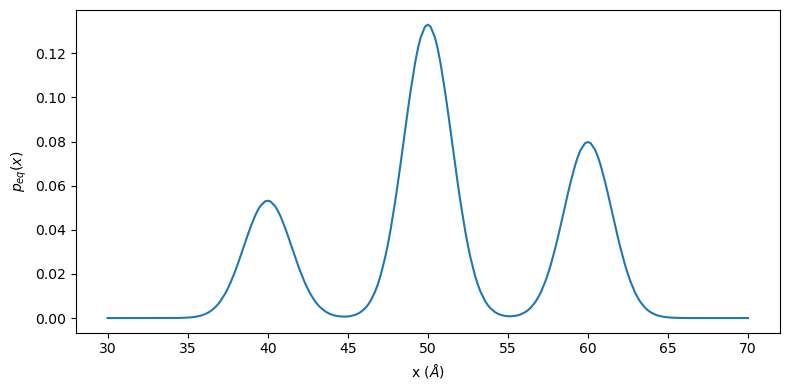

In [4]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(8,4))

ax.plot(xref, peq)
ax.set_xlabel("x (\$ \\AA \$)")
ax.set_ylabel("\$ p_{eq}(x) \$")

plt.tight_layout()
#plt.savefig("Gaussian_Kde_harmonic_well.svg")
plt.show()

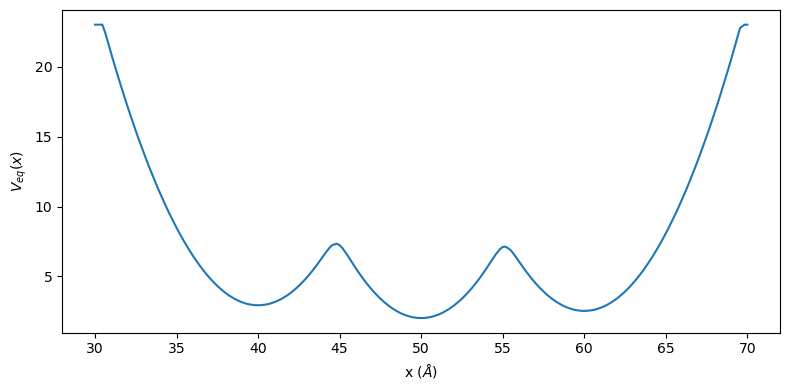

In [5]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(8,4))

ax.plot(xref, Veq_spl(xref[:,1]))
ax.set_xlabel("x (\$ \\AA \$)")
ax.set_ylabel("\$ V_{eq}(x) \$")

plt.tight_layout()
#plt.savefig("Gaussian_Kde_harmonic_well.svg")
plt.show()

### Part 3: Langenvin dynamics simulations

In [8]:
# physical parameters
save_freq = 1e-9 # unit: s, Save trajectory per 100 ps
total_times = 10e-6 # unit: s, total simulate 10 us, 10e-6
dt = 1e-11 # unit: s  # Integration Times 1ps
#kbT = 1
D = 4.845e9; # Diffusion coefficient, unit: angstrom^2 s-1
tau = Int(round(total_times / save_freq, digits=0))  # Number of photons
n_interval = Int(round(save_freq / dt, digits=0));

time_info = @sprintf "Save trajectory per %d timesteps. There will be %d data points." n_interval tau
println(time_info)

Save trajectory per 100 timesteps. There will be 10000 data points.


In [9]:
# Initialize Variables
y_record = zeros(tau+1, 1)  # In HMM, observing variables Y(t)
t_record = zeros(tau+1, 1)

ypos = xavg # Initial Position, from mean position
t = 0

# Simulation Start
for tau_id = 1:tau
    y_record[tau_id] = ypos
    t_record[tau_id] = t
    for i = 1:n_interval
        #F = force_doulbe_well_width_height(ypos, W, H, xavg)
        #F = force_harmonic_well_k_mean(ypos, k_ref, xavg)
        F = -derivative(Veq_spl, ypos)
        ypos = ypos + D*dt*F + (dt*2*D)^(1/2) * randn()
        t += dt   
    end
end
y_record[tau+1] = ypos
t_record[tau+1] = t;

### Part 4: Save trajectory or Read trajectory

In [12]:
# Save simulated trajectory to jld file
f_out = "/home/yizaochen/codes/julia/md_pisl/trajectory/toc_traj.jld"
save(f_out, "y_record", y_record, "t_record", t_record, "xref", xref, "rho_eq", rho_eq, "D", D)

In [77]:
# Read simulated trajectory from jld file
f_in = "/home/yizaochen/codes/julia/md_pisl/trajectory/toc_traj.jld"
y_record = load(f_in, "y_record")
t_record = load(f_in, "t_record")
xref = load(f_in, "xref")
rho_eq = load(f_in, "rho_eq")
D = load(f_in, "D");

### Part 5: Plot

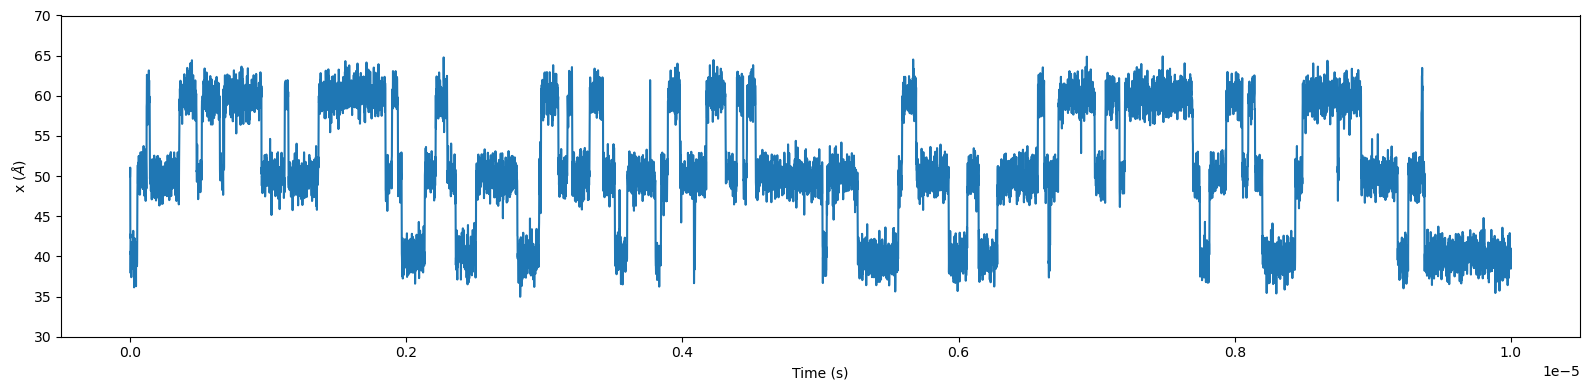

In [11]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(16,4))

ax.plot(t_record, y_record)
ax.set_xlabel("Time (s)")
ax.set_ylabel("x (\$ \\AA \$)")
ax.set_ylim(30,70)

plt.tight_layout()
#plt.savefig("toc_traj.svg")
plt.show()